In [1]:
import io
import glob
import os
# from PIL import Image, ImageOps
from stl import mesh
# import xml.etree.cElementTree as ETree
# import zipfile
import numpy as np
import math
import multiprocessing as mp
import matplotlib.pyplot as plt
import string
import random

class PolygonRepair():
	def __init__(self, segments, dimensions):
		# Maps endpoints to the polygon they form
		self.loops = []
		# Populate initially
		self.polylines = []
		self.original_segments = segments
		self.dimensions = dimensions
		self.collapse_segments()

	def collapse_segments(self):
		self.loops = []
		self.polylines = []
		for polyline in self.find_polylines(self.original_segments):
			if polyline[0] == polyline[-1]:
				self.loops.append(polyline)
			else:
				self.polylines.append(polyline)

	def repair_all(self):
		while self.polylines:
			self.repair_polyline()
			old_seg_length = len(self.polylines)
			self.collapse_segments()
			assert old_seg_length - 1 == len(self.polylines)
		assert len(self.polylines) == 0

	def repair_polyline(self):
		# Search starts at the end of an arbitrary polyline
		search_start = self.polylines[0][-1]
		# Search will conclude when it finds the beginning of any polyline (including itself)
		search_ends = [polyline[0] for polyline in self.polylines]
		polyline_endpoints = [(polyline[0], polyline[-1]) for polyline in self.polylines]
		max_iterations = self.dimensions[0] + self.dimensions[1]
		end = self.winding_number_search(search_start, search_ends, polyline_endpoints, max_iterations)
		self.original_segments.append((search_start, end))

	def find_polylines(self, segments):
		polylines = []
		segment_forward_dict = {}
		segment_backward_dict = {}

		for segment in segments:
			start, end = segment
			if start not in segment_forward_dict:
				segment_forward_dict[start] = []
			segment_forward_dict[start].append(end)
			if end not in segment_backward_dict:
				segment_backward_dict[end] = []
			segment_backward_dict[end].append(start)

		while len(segment_forward_dict) > 0:
			start = list(segment_forward_dict.keys())[0]
			polyline = [start]

			while True:
				if start not in segment_forward_dict:
					break
				next_points = segment_forward_dict[start]
				end = next_points[0]

				segment_forward_dict[start].remove(end)
				if len(segment_forward_dict[start]) == 0:
					del segment_forward_dict[start]
				segment_backward_dict[end].remove(start)
				if len(segment_backward_dict[end]) == 0:
					del segment_backward_dict[end]
				polyline.append(end)
				start = end

			start = polyline[0]
			while True:
				if start not in segment_backward_dict:
					break
				next_points = segment_backward_dict[start]
				end = next_points[0]

				segment_backward_dict[start].remove(end)
				if len(segment_backward_dict[start]) == 0:
					del segment_backward_dict[start]
				segment_forward_dict[end].remove(start)
				if len(segment_forward_dict[end]) == 0:
					del segment_forward_dict[end]
				polyline.insert(0, end)
				start = end
			polylines.append(polyline)

		return polylines

	def find_polyline_endpoints(self, segs):
		start_to_end = dict()
		end_to_start = dict()

		for start, end in segs:
			actual_start = end_to_start.get(start, start)
			actual_end = start_to_end.get(end, end)

			if actual_start == actual_end:
				del end_to_start[actual_start]
				del start_to_end[actual_start]
				continue

			start_to_end[actual_start] = actual_end
			end_to_start[actual_end] = actual_start

			if start in end_to_start:
				del end_to_start[start]
			if end in start_to_end:
				del start_to_end[end]

		return start_to_end

	def atan_sum(self, f1, f2):
		x1, y1 = f1
		x2, y2 = f2
		return (x1 * x2 - y1 * y2, y1 * x2 + x1 * y2)

	def atan_diff(self, f1, f2):
		x1, y1 = f1
		x2, y2 = f2
		return (x1 * x2 + y1 * y2, y1 * x2 - x1 * y2)

	def subtract(self, s1, s2):
		return (s1[0] - s2[0], s1[1] - s2[1])

	def add(self, s1, s2):
		return (s1[0] + s2[0], s1[1] + s2[1])

	def winding_contour_pole(self, pos, pt, repel):
		x, y = self.subtract(pos, pt)
		dist2 = (x ** 2 + y ** 2)
		cx = x / dist2
		cy = y / dist2
		if repel:
			return (cx, cy)
		else:
			return (-cx, -cy)

	def normalize(self, pt):
		x, y = pt
		dist = math.sqrt(x ** 2 + y ** 2)
		return (x / dist, y / dist)

	def distance_squared(self, p1, p2):
		x1, y1 = p1
		x2, y2 = p2
		return (y2 - y1) ** 2 + (x2 - x1) ** 2

	def initial_direction(self, pt, polyline_endpoints):
		accum = (1, 0)
		for start, end in polyline_endpoints:
			if start != pt:
				accum = self.atan_sum(accum, self.subtract(start, pt))
			if end != pt:
				accum = self.atan_diff(accum, self.subtract(end, pt))
			accum = self.normalize(accum)
		return np.array(accum)

	def winding_contour(self, pos, segs):
		accum = (0, 0)
		for start, end in segs:
			start_vec = self.winding_contour_pole(pos, start, repel=False)
			accum = self.add(accum, start_vec)
			end_vec = self.winding_contour_pole(pos, end, repel=True)
			accum = self.add(accum, end_vec)
		return self.normalize(accum)

	def winding_number_search(self, start, ends, polyline_endpoints, max_iterations):
		direction = self.initial_direction(start, polyline_endpoints)
		pos = start + (direction * 0.1)
		for _ in range(max_iterations):
			direction = self.winding_contour(pos, polyline_endpoints)
			pos = pos + direction
			for end in ends:
				if self.distance_squared(pos, end) < 1:
					return end
		raise Exception("Failed to repair mesh")


class Convert_STL_to_voxels:
	def __init__(self, stl_file, resolution=100, voxel_size=None, output_file=None, parallel=True) -> None:
		self._mesh = stl_file
		self.resolution = resolution
		self.voxel_size = voxel_size
		self.output_file = output_file
		self.parallel = parallel

		# This will store the voxelized output as a numpy array
		self.voxel_data = None

		# Convert the mesh to voxels immediately upon initialization
		# self.convert_mesh()

	def convert_mesh(self):
		# Convert the mesh and store the voxel data as an attribute
		self.voxel_data, scale, shift = self.convert_meshes([self._mesh], self.resolution, self.voxel_size, self.parallel)
		# self.voxel_data, scale, shift = self.convert_meshes([self._mesh])

	def convert_meshes(self, meshes=None, resolution=100, voxel_size=None, parallel=True):
		if meshes is None:
			meshes = [self._mesh]
		mesh_min, mesh_max = self.calculate_mesh_limits(meshes)
		scale, shift, shape = self.calculate_scale_and_shift(mesh_min, mesh_max, self.resolution, self.voxel_size)
		vol = np.zeros(shape[::-1], dtype=np.int8)
		for mesh_ind, org_mesh in enumerate(meshes):
			self.scale_and_shift_mesh(org_mesh, scale, shift)
			cur_vol = self.mesh_to_plane(org_mesh, shape, self.parallel)
			vol[cur_vol] = mesh_ind + 1
		return vol, scale, shift

	def convert_file(self, output_file_path=None, pad=1, parallel=False):
		vol, scale, shift = self.convert_files([self._mesh], output_file_path, resolution=self.resolution, voxel_size=self.voxel_size, pad=pad, parallel=parallel)
		# print(f"vol: {vol}, scale: {scale}, shift: {shift}")  # Debugging print to ensure values are correct
		total_voxels = np.sum(vol == 1)
		print(f"Total number of voxels: {total_voxels}")
		print(f"3D Shape: {vol.shape}\nScale: {scale}\nShift: {shift}")
		dimensions_cm = (vol.shape[0]/scale[0]/10,vol.shape[1]/scale[1]/10,vol.shape[2]/scale[2]/10)
		dimensions_mm = (vol.shape[0]/scale[0],vol.shape[1]/scale[1],vol.shape[2]/scale[2])
		box_size_cm = (dimensions_cm[0]/vol.shape[0], dimensions_cm[1]/vol.shape[1], dimensions_cm[2]/vol.shape[2])
		box_size_mm = (dimensions_mm[0]/vol.shape[0], dimensions_mm[1]/vol.shape[1], dimensions_mm[2]/vol.shape[2])
		print(f"Original Dimensions (cm): {dimensions_cm}")
		print(f"Original Dimensions (mm): {dimensions_mm}")
		print(f"Voxel Size (cm): {box_size_cm}")
		print(f"Voxel Size (mm): {box_size_mm}")
		return vol, scale, shift, dimensions_cm, box_size_cm, dimensions_mm, box_size_mm

	def convert_files(self, input_file_paths, output_file_path, colors=[(255, 255, 255)], resolution=100, voxel_size=None, pad=1, parallel=False):
		meshes = []
		for input_file_path in input_file_paths:
			mesh_obj = mesh.Mesh.from_file(input_file_path)
			org_mesh = np.hstack((mesh_obj.v0[:, np.newaxis], mesh_obj.v1[:, np.newaxis], mesh_obj.v2[:, np.newaxis]))
			meshes.append(org_mesh)

		vol, scale, shift = self.convert_meshes(meshes)
		assert vol is not None, "Voxel data (vol) is None"
		assert scale is not None, "Scale is None"
		assert shift is not None, "Shift is None"
		
		# print(f"vol: {vol}, scale: {scale}, shift: {shift}")

		if self.output_file is not None:
			_output_file_pattern, output_file_extension = os.path.splitext(output_file_path)
			if output_file_extension == '.png':
				vol = np.pad(vol, pad)
				self.export_pngs(vol, output_file_path, colors)
			elif output_file_extension == '.xyz':
				self.export_xyz(vol, output_file_path, scale, shift)
			elif output_file_extension == '.svx':
				self.export_svx(vol, output_file_path, scale, shift)
			elif output_file_extension == '.npy':
				self.export_npy(vol, output_file_path, scale, shift)

		return vol, scale, shift

	# def export_pngs(self, voxels, output_file_path, colors):
	# 	output_file_pattern, _output_file_extension = os.path.splitext(output_file_path)
	# 	file_list = glob.glob(output_file_pattern + '_*.png')
	# 	for file_path in file_list:
	# 		try:
	# 			os.remove(file_path)
	# 		except Exception:
	# 			print("Error while deleting file : ", file_path)

	# 	z_size = voxels.shape[0]
	# 	size = str(len(str(z_size + 1)))
	# 	colors = [(0, 0, 0)] + colors
	# 	palette = [channel for color in colors for channel in color]
	# 	for height in range(z_size):
	# 		print('export png %d/%d' % (height, z_size))
	# 		if colors == [(0, 0, 0), (255, 255, 255)]:
	# 			img = Image.fromarray(voxels[height].astype('bool'))
	# 		else:
	# 			img = Image.fromarray(voxels[height].astype('uint8'), mode='P')
	# 			img.putpalette(palette)
	# 		img = ImageOps.flip(img)
	# 		path = (output_file_pattern + "_%0" + size + "d.png") % height
	# 		img.save(path)

	def export_xyz(self, voxels, output_file_path, scale, shift):
		voxels = voxels.astype(bool)
		output = open(output_file_path, 'w')
		for z in range(voxels.shape[0]):
			for y in range(voxels.shape[1]):
				for x in range(voxels.shape[2]):
					if voxels[z][y][x]:
						point = (np.array([x, y, z]) / scale) + shift
						output.write('%s %s %s\n' % tuple(point))
		output.close()

	def export_npy(self, voxels, output_file_path, scale, shift):
		voxels = voxels.astype(bool)
		out = []
		for z in range(voxels.shape[0]):
			for y in range(voxels.shape[1]):
				for x in range(voxels.shape[2]):
					if voxels[z][y][x]:
						point = (np.array([x, y, z]) / scale) + shift
						out.append(point)
		np.save(output_file_path, out)

	# def export_svx(self, voxels, output_file_path, scale, shift):
	# 	voxels = voxels.astype(bool)
	# 	z_size, y_size, x_size = voxels.shape
	# 	size = str(len(str(z_size)) + 1)
	# 	root = ETree.Element("grid", attrib={"gridSizeX": str(x_size),
	# 										 "gridSizeY": str(y_size),
	# 										 "gridSizeZ": str(z_size),
	# 										 "voxelSize": str(1.0 / scale / 1000),  # STL is probably in mm, and svx needs meters
	# 										 "subvoxelBits": "8",
	# 										 "originX": str(shift[0]),
	# 										 "originY": str(shift[1]),
	# 										 "originZ": str(shift[2]),
	# 										 })
	# 	manifest = ETree.tostring(root)
	# 	with zipfile.ZipFile(output_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
	# 		for height in range(z_size):
	# 			img = Image.fromarray(voxels[height])
	# 			img = ImageOps.flip(img)
	# 			output = io.BytesIO()
	# 			img.save(output, format="PNG")
	# 			zip_file.writestr(("density/slice%0" + size + "d.png") % height, output.getvalue())
	# 		zip_file.writestr("manifest.xml", manifest)

	def repaired_lines_to_voxels(self, line_list, pixels, plane_shape):
		if not line_list:
			return
		segments = [[tuple(pt.tolist())[:2] for pt in seg] for seg in line_list]
		wq = PolygonRepair(segments, plane_shape)
		wq.repair_all()
		new_line_list = []
		for polyline in wq.loops:
			for i in range(len(polyline) - 1):
				new_line_list.append((polyline[i], polyline[i+1]))
		self.lines_to_voxels(new_line_list, pixels)

	def lines_to_voxels(self, line_list, pixels):
		current_line_indices = set()
		x = 0
		i = 0
		events = self.generate_line_events(line_list)
		while i < len(events):
			event_x, status, line_ind = events[i]
			if event_x > x:
				lines = [line_list[ind] for ind in current_line_indices]
				self.paint_y_axis(lines, pixels, x)
				x += 1
			elif event_x <= x and status == 'begin':
				assert line_ind not in current_line_indices
				current_line_indices.add(line_ind)
				i += 1
			elif event_x <= x and status == 'end':
				assert line_ind in current_line_indices
				current_line_indices.remove(line_ind)
				i += 1

	def generate_y(self, p1, p2, x):
		x1, y1 = p1[:2]
		x2, y2 = p2[:2]
		assert x1 != x2

		dy = (y2 - y1)
		dx = (x2 - x1)
		y = dy * (x - x1) / dx + y1

		inside_change = 0
		if x1 > x2:
			inside_change = -1
		elif x1 < x2:
			inside_change = 1
		return y, inside_change

	def paint_y_axis(self, lines, pixels, x):
		inside = 0
		target_ys = [self.generate_y(line[0], line[1], x) for line in lines]
		target_ys.sort()
		assert len(target_ys) % 2 == 0

		yi = 0
		for target_y, inside_change in target_ys:
			target_y = int(np.ceil(target_y))
			assert target_y >= 0
			if inside > 0:
				pixels[yi:target_y, int(x)] = True

			inside += inside_change
			yi = target_y
		assert inside == 0, f'an error has occurred at x{x} inside:{inside} lines:{lines}'

	def generate_line_events(self, line_list):
		events = []
		for i, line in enumerate(line_list):
			first, second = sorted(line, key=lambda pt: pt[0])
			if first[0] == second[0]:
				continue
			events.append((first[0], 'begin', i))
			events.append((second[0], 'end', i))
		return sorted(events)

	def mesh_to_plane(self, mesh, bounding_box, parallel):
		if parallel:
			pool = mp.Pool(mp.cpu_count())
			result_ids = []

		vol = np.zeros(bounding_box[::-1], dtype=bool)
		current_mesh_indices = set()
		z = 0
		i = 0
		events = self.generate_tri_events(mesh)
		while i < len(events) and z < bounding_box[2]:
			event_z, status, tri_ind = events[i]
			if event_z > z:
				mesh_subset = [mesh[ind] for ind in current_mesh_indices]
				if parallel:
					result_id = pool.apply_async(self.paint_z_plane, args=(mesh_subset, z, vol.shape[1:]))
					result_ids.append(result_id)
				else:
					_, pixels = self.paint_z_plane(mesh_subset, z, vol.shape[1:])
					vol[z] = pixels
				z += 1
			elif event_z <= z and status == 'begin':
				assert tri_ind not in current_mesh_indices
				current_mesh_indices.add(tri_ind)
				i += 1
			elif event_z <= z and status == 'end':
				assert tri_ind in current_mesh_indices
				current_mesh_indices.remove(tri_ind)
				i += 1

		if parallel:
			results = [r.get() for r in result_ids]
			for z, pixels in results:
				vol[z] = pixels

			pool.close()
			pool.join()

		return vol

	def paint_z_plane(self, mesh, height, plane_shape):
		print('Processing layer %d' % height)

		pixels = np.zeros(plane_shape, dtype=bool)
		lines = []
		for triangle in mesh:
			points = self.triangle_to_intersecting_points(triangle, height)
			if len(points) == 2:
				lines.append(tuple(points))
			if len(points) == 3:
				for i in range(3):
					pt = points[i]
					pt2 = points[(i + 1) % 3]
					lines.append((pt, pt2))

		self.repaired_lines_to_voxels(lines, pixels, plane_shape)
		return height, pixels

	def linear_interpolation(self, p1, p2, distance):
		return p1 * (1-distance) + p2 * distance

	def triangle_to_intersecting_points(self, triangle, height):
		assert len(triangle) == 3
		points = []
		start_index = max(range(3), key=lambda i: triangle[i][2])
		if triangle[(start_index+1) % 3][2] == height:
			start_index = (start_index+1) % 3
		for i in range(start_index, start_index + 3):
			pt = triangle[i % 3]
			pt2 = triangle[(i+1) % 3]
			if pt[2] == height:
				points.append(pt)
			elif (pt[2] < height and pt2[2] > height) or (pt[2] > height and pt2[2] < height):
				intersection = self.where_line_crosses_z(pt, pt2, height)
				points.append(intersection)
		return points

	def where_line_crosses_z(self, p1, p2, z):
		if p1[2] > p2[2]:
			p1, p2 = p2, p1
		if p2[2] == p1[2]:
			distance = 0
		else:
			distance = (z - p1[2]) / (p2[2] - p1[2])
		return self.linear_interpolation(p1, p2, distance)

	def calculate_mesh_limits(self, meshes):
		mesh_min = meshes[0].min(axis=(0, 1))
		mesh_max = meshes[0].max(axis=(0, 1))
		for mesh in meshes[1:]:
			mesh_min = np.minimum(mesh_min, mesh.min(axis=(0, 1)))
			mesh_max = np.maximum(mesh_max, mesh.max(axis=(0, 1)))
		return mesh_min, mesh_max

	def calculate_scale_and_shift(self, mesh_min, mesh_max, resolution, voxel_size):
		bounding_box = mesh_max - mesh_min
		if voxel_size is not None:
			resolution = bounding_box / voxel_size
		else:
			if isinstance(resolution, int):
				resolution = resolution * bounding_box / bounding_box[2]
			else:
				resolution = np.array(resolution)
		scale = resolution / bounding_box
		int_resolution = np.ceil(resolution).astype(int)
		centering_offset = (int_resolution - resolution - 1) / (2 * scale)
		shift = mesh_min - centering_offset
		return scale, shift, int_resolution

	def scale_and_shift_mesh(self, mesh, scale, shift):
		for i in range(3):
			mesh[..., i] = (mesh[..., i] - shift[i]) * scale[i]

	def generate_tri_events(self, mesh):
		events = []
		for i, tri in enumerate(mesh):
			bottom, middle, top = sorted(tri, key=lambda pt: pt[2])
			events.append((bottom[2], 'begin', i))
			events.append((top[2], 'end', i))
		return sorted(events, key=lambda tup: tup[0])


Processing layer 0
Processing layer 1
Processing layer 2
Total number of voxels: 525
3D Shape: (3, 40, 43)
Scale: [0.42857143 0.42857146 0.42857143]
Shift: [-49.00000064 -45.4499938    0.16666666]
Original Dimensions (cm): (0.6999999930461248, 9.333332591586702, 10.033333233661121)
Original Dimensions (mm): (6.999999930461248, 93.33332591586702, 100.33333233661122)
Voxel Size (cm): (0.23333333101537493, 0.23333331478966754, 0.23333333101537493)
Voxel Size (mm): (2.3333333101537495, 2.3333331478966755, 2.3333333101537495)


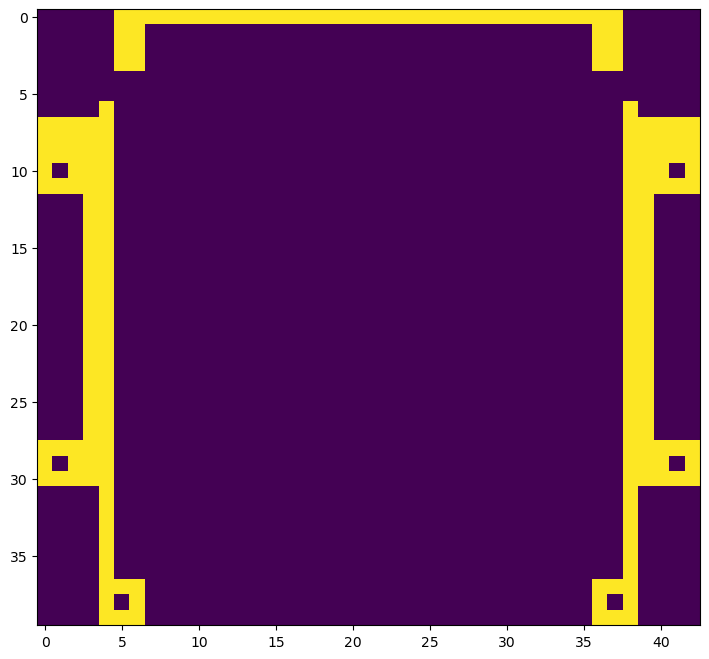

In [7]:
# stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/1U_skelton_onlyframe_ascii.stl"
stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/base_v3_ascii.stl"
# stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/pb_cover_full_ascii.stl"
# stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/top_v2_stp1_01_ascii.stl"

resolution=3
voxel_size=None
parallel=False

new_obj = Convert_STL_to_voxels(stl_file=stl_file, resolution=resolution, voxel_size=voxel_size, parallel=parallel)
vox, scale, shift, dim_cm, vox_cm, dim_mm, vox_mm = new_obj.convert_file()


fig = plt.figure(figsize=(16, 8))
plt.imshow(vox[0])
# plt.imshow(vox[1])
# plt.imshow(vox[2])
# plt.imshow(vox[3])
# plt.imshow(vox[resolution//2])
# plt.imshow(vox[resolution-1])
# plt.imshow(vox[7])
# plt.imshow(vox[15])
# plt.imshow(vox[7])

In [3]:
## All Cubes
def voxel_to_megalib_file(vox, scale, shift, voxel_size=[1, 1, 1], material="Pb", base_position=[0, 0, 0], base_rotation=[0, 0, 0], mother_volume="WorldVolume", output_file="output.geo"):
	"""
	Converts each filled voxel (value of 1) in the voxel grid to a MEGAlib compatible geometry string and writes it to a .geo file.

	Parameters:
	- vox: The 3D numpy array representing the voxel grid.
	- scale: The scaling factors applied to the original mesh in x, y, z directions.
	- shift: The shift applied to the original mesh in x, y, z directions.
	- voxel_size: The physical size of each voxel in the grid (default is [1, 1, 1]).
	- material: The material of the voxel (default is "Pb").
	- base_position: The base position for the entire model (default is [0, 0, 0]).
	- base_rotation: The base rotation for the entire model (default is [0, 0, 0]).
	- mother_volume: The mother volume name in MEGAlib (default is "WorldVolume").
	- output_file: The name of the output file (default is "output.geo").

	Returns:
	- None. Writes the MEGAlib geometry description to the specified output file.
	"""

	def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
		return ''.join(random.choice(chars) for _ in range(size))
		
	# Count total number of filled voxels
	total_voxels = np.sum(vox == 1)
	print(f"Total filled voxels to process: {total_voxels}")

	lines = []
	cube_counter = 0
	unions = []
	processed_voxels = 0
	
	with open(output_file, 'w') as file:
		# Iterate through the voxel grid
		for i in range(vox.shape[0]):
			for j in range(vox.shape[1]):
				for k in range(vox.shape[2]):
					if vox[i, j, k] == 1:
						# Convert voxel grid position to original coordinate system
						# x = (i / scale[0]) + shift[0]
						# y = (j / scale[1]) + shift[1]
						# z = (k / scale[2]) + shift[2]
						pos_x = (i * voxel_size[0]) + shift[0]
						pos_y = (j * voxel_size[1]) + shift[1]
						pos_z = (k * voxel_size[2]) + shift[2]

						# Calculate the voxel's position in MEGAlib coordinates
						# pos_x = x * voxel_size[0]
						# pos_y = y * voxel_size[1]
						# pos_z = z * voxel_size[2]
						# pos_x = base_position[0] + x * voxel_size[0]
						# pos_y = base_position[1] + y * voxel_size[1]
						# pos_z = base_position[2] + z * voxel_size[2]

						# Create cube definition
						cube_name = f"C{cube_counter}"
						orientation_name = f"{cube_name}Orientation"
						cube_string = (
							f"Shape BRIK {cube_name}\n"
							f"{cube_name}.Parameters {voxel_size[0]:.3f} {voxel_size[1]:.3f} {voxel_size[2]:.3f}\n"
							f"Orientation {orientation_name}\n"
							f"{orientation_name}.Position {pos_x:.3f} {pos_y:.3f} {pos_z:.3f}\n"
							f"{orientation_name}.Rotation 0 0 0\n\n" # {base_rotation[0]} {base_rotation[1]} {base_rotation[2]}
						)
						# lines.append(cube_string)
						file.write(cube_string)

						# Keep track of unions for later
						unions.append(cube_name)
						cube_counter += 1
						processed_voxels += 1

						# Log progress every 10% of total voxels processed
						if processed_voxels % (total_voxels // 10) == 0:
							percentage_done = (processed_voxels / total_voxels) * 100
							print(f"Progress: {percentage_done:.2f}% ({processed_voxels}/{total_voxels} voxels processed)")


		# Create the union of all cubes
		previous_union = None
		for index, cube_name in enumerate(unions):
			if index == 0:
				previous_union = cube_name
			else:
				current_union = f"{previous_union}_{cube_name}"
				union_string = (
					f"Shape Union {current_union}\n"
					f"{current_union}.Parameters {previous_union} {cube_name} {cube_name}Orientation\n\n"
				)
				# lines.append(union_string)
				file.write(union_string)
				previous_union = current_union

		# Create the final volume
		final_union = previous_union
		rstring = f"{id_generator()}"
		volume_string = (
			f"Volume CadModelUnion{rstring}\n"
			f"CadModelUnion{rstring}.Shape {final_union}\n"
			f"CadModelUnion{rstring}.Visibility 1\n"
			f"CadModelUnion{rstring}.Color 34\n"
			f"CadModelUnion{rstring}.Material {material}\n"
			f"CadModelUnion{rstring}.Position {base_position[0]} {base_position[1]} {base_position[2]}\n"
			f"CadModelUnion{rstring}.Rotation {base_rotation[0]} {base_rotation[1]} {base_rotation[2]}\n"
			f"CadModelUnion{rstring}.Mother {mother_volume}\n"
		)
		file.write(volume_string)
	file.close()

	print(f"MEGAlib geometry successfully written to {output_file}")

## Try to group pixels along the z direction
def voxel_to_megalib_file_z_bin(vox, scale, shift, voxel_size=[1, 1, 1], material="Pb", base_position=[0, 0, 0], base_rotation=[0, 0, 0], mother_volume="WorldVolume", output_file="output.geo"):
	"""
	Converts each filled voxel (value of 1) in the voxel grid to a MEGAlib compatible geometry string and writes it to a .geo file.
	Includes functionality to merge vertical stacks of filled voxels along the z-axis.

	Parameters:
	- vox: The 3D numpy array representing the voxel grid.
	- scale: The scaling factors applied to the original mesh in x, y, z directions.
	- shift: The shift applied to the original mesh in x, y, z directions.
	- voxel_size: The physical size of each voxel in the grid (default is [1, 1, 1]).
	- material: The material of the voxel (default is "Pb").
	- base_position: The base position for the entire model (default is [0, 0, 0]).
	- base_rotation: The base rotation for the entire model (default is [0, 0, 0]).
	- mother_volume: The mother volume name in MEGAlib (default is "WorldVolume").
	- output_file: The name of the output file (default is "output.geo").

	Returns:
	- None. Writes the MEGAlib geometry description to the specified output file.
	"""

	def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
		return ''.join(random.choice(chars) for _ in range(size))

	def merge_vertical_voxels(vox):
		"""
		Merges vertical stacks of filled voxels (value of 1) along the z-axis into single or multiple rectangular voxels,
		accounting for gaps in between, and tracks which voxels have been processed.

		Parameters:
		- vox: The 3D numpy array representing the voxel grid.

		Returns:
		- merged_vox: A new 3D numpy array with merged vertical stacks.
		- rect_list: A list of tuples representing the merged rectangles in the form (x_index, y_index, z_start, length).
		- visited: A 3D numpy array indicating which voxels have been processed.
		"""
		merged_vox = np.zeros_like(vox)
		visited = np.zeros_like(vox, dtype=bool)
		rect_list = []

		for i in range(vox.shape[0]):
			for j in range(vox.shape[1]):
				k = 0
				while k < vox.shape[2]:
					if vox[i, j, k] == 1 and not visited[i, j, k]:
						start_k = k
						while k < vox.shape[2] and vox[i, j, k] == 1:
							k += 1
						length = k - start_k  # Calculate the length of the rectangle
						# Store the rectangular voxel's starting z-index and length along with x and y indices
						rect_list.append((i, j, start_k, length))
						# Mark all the voxels in this rectangle as visited
						merged_vox[i, j, start_k:start_k+length] = 1
						visited[i, j, start_k:start_k+length] = True  # Mark as visited after forming the rectangle
					else:
						k += 1  # Move to the next voxel if this one is not part of a new rectangle

		return merged_vox, rect_list, visited

	def sort_rectangles_for_xy_touching(rect_list):
		"""
		Sorts rectangles so that each rectangle touches the next one along the x or y axis.
		Parameters:
		- rect_list: A list of tuples representing the rectangles in the form (x_index, y_index, z_start, length).
		Returns:
		- sorted_rect_list: A sorted list of tuples where each rectangle touches the next one along the x or y axis.
		"""
		# First, sort by x_index and y_index to get a baseline order
		rect_list.sort(key=lambda x: (x[0], x[1]))
		sorted_rect_list = []

		if not rect_list:
			return sorted_rect_list

		# Start with the first rectangle
		current_rect = rect_list[0]
		sorted_rect_list.append(current_rect)
		rect_list = rect_list[1:]
		
		while rect_list:
			next_rect = None
			for i, rect in enumerate(rect_list):
				# Check if the rectangle can touch the current one along the x or y axis
				if (rect[0] == current_rect[0] and abs(rect[1] - current_rect[1]) == 1) or \
				(rect[1] == current_rect[1] and abs(rect[0] - current_rect[0]) == 1):
					next_rect = rect
					break
			
			if next_rect:
				sorted_rect_list.append(next_rect)
				rect_list.pop(i)
				current_rect = next_rect
			else:
				# If no touching rectangle is found, add the next available rectangle and continue
				current_rect = rect_list.pop(0)
				sorted_rect_list.append(current_rect)
		return sorted_rect_list


	# Merge vertical voxels along the z-axis
	merged_vox, rect_list, visited = merge_vertical_voxels(vox)

	# Count total number of merged rectangles
	total_rectangles = len(rect_list)
	print(f"Total merged rectangles to process: {total_rectangles}")

	lines = []
	cube_counter = 0
	unions = []
	processed_rectangles = 0

	with open(output_file, 'w') as file:
		# Iterate through the list of merged rectangles

		# Sort the list based on i (x direction) and j (y direction) before the loop
		sorted_rect_list = sort_rectangles_for_xy_touching(rect_list)

		for rect in sorted_rect_list:
			i, j, start_k, length = rect
			pos_x = (i * voxel_size[0]) + (shift[0]/10)
			pos_y = (j * voxel_size[1]) + (shift[1]/10)
			pos_z = (start_k * voxel_size[2]) + (shift[2]/10)
			rect_height = length * voxel_size[2] / 2
			# Create rectangular voxel definition
			cube_name = f"C{cube_counter}"
			orientation_name = f"{cube_name}Orientation"
			cube_string = (
				f"Shape BRIK {cube_name}\n"
				f"{cube_name}.Parameters {voxel_size[0]:.3f} {voxel_size[1]:.3f} {rect_height:.3f}\n"
				f"Orientation {orientation_name}\n"
				f"{orientation_name}.Position {pos_x:.3f} {pos_y:.3f} {pos_z + (rect_height):.3f}\n"
				f"{orientation_name}.Rotation 0 0 0\n\n"
			)
			file.write(cube_string)
			# Keep track of unions for later
			unions.append(cube_name)
			cube_counter += 1
			processed_rectangles += 1
				
			
			# Log progress every 10% of total rectangles processed
			if processed_rectangles % (total_rectangles // 10) == 0:
				percentage_done = (processed_rectangles / total_rectangles) * 100
				print(f"Progress: {percentage_done:.2f}% ({processed_rectangles}/{total_rectangles} rectangles processed)")

		# Create the union of all rectangles
		previous_union = None
		for index, cube_name in enumerate(unions):
			if index == 0:
				previous_union = cube_name
			else:
				current_union = f"{previous_union}_{cube_name}"
				union_string = (
					f"Shape Union {current_union}\n"
					f"{current_union}.Parameters {previous_union} {cube_name} {cube_name}Orientation\n\n"
				)
				file.write(union_string)
				previous_union = current_union

		# Create the final volume
		final_union = previous_union
		rstring = f"{id_generator()}"
		volume_string = (
			f"Volume CadModelUnion{rstring}\n"
			f"CadModelUnion{rstring}.Shape {final_union}\n"
			f"CadModelUnion{rstring}.Visibility 1\n"
			f"CadModelUnion{rstring}.Color 34\n"
			f"CadModelUnion{rstring}.Material {material}\n"
			f"CadModelUnion{rstring}.Position {base_position[0]} {base_position[1]} {base_position[2]}\n"
			f"CadModelUnion{rstring}.Rotation {base_rotation[0]} {base_rotation[1]} {base_rotation[2]}\n"
			f"CadModelUnion{rstring}.Mother {mother_volume}\n"
		)
		file.write(volume_string)
	file.close()

	print(f"MEGAlib geometry successfully written to {output_file}")

def voxel_to_megalib_file_z_bin_pure(vox, scale, shift, voxel_size=[1, 1, 1], material="Pb", base_position=[0, 0, 0], base_rotation=[0, 0, 0], mother_volume="WorldVolume", output_file="output.geo"):
	"""
	Converts each filled voxel (value of 1) in the voxel grid to a MEGAlib compatible geometry string and writes it to a .geo file.
	Includes functionality to merge vertical stacks of filled voxels along the z-axis.

	Parameters:
	- vox: The 3D numpy array representing the voxel grid.
	- scale: The scaling factors applied to the original mesh in x, y, z directions.
	- shift: The shift applied to the original mesh in x, y, z directions.
	- voxel_size: The physical size of each voxel in the grid (default is [1, 1, 1]).
	- material: The material of the voxel (default is "Pb").
	- base_position: The base position for the entire model (default is [0, 0, 0]).
	- base_rotation: The base rotation for the entire model (default is [0, 0, 0]).
	- mother_volume: The mother volume name in MEGAlib (default is "WorldVolume").
	- output_file: The name of the output file (default is "output.geo").

	Returns:
	- None. Writes the MEGAlib geometry description to the specified output file.
	"""

	def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
		return ''.join(random.choice(chars) for _ in range(size))

	def merge_vertical_voxels(vox):
		"""
		Merges vertical stacks of filled voxels (value of 1) along the z-axis into single or multiple rectangular voxels,
		accounting for gaps in between, and tracks which voxels have been processed.

		Parameters:
		- vox: The 3D numpy array representing the voxel grid.

		Returns:
		- merged_vox: A new 3D numpy array with merged vertical stacks.
		- rect_list: A list of tuples representing the merged rectangles in the form (x_index, y_index, z_start, length).
		- visited: A 3D numpy array indicating which voxels have been processed.
		"""
		merged_vox = np.zeros_like(vox)
		visited = np.zeros_like(vox, dtype=bool)
		rect_list = []

		for i in range(vox.shape[0]):
			for j in range(vox.shape[1]):
				k = 0
				while k < vox.shape[2]:
					if vox[i, j, k] == 1 and not visited[i, j, k]:
						start_k = k
						while k < vox.shape[2] and vox[i, j, k] == 1:
							k += 1
						length = k - start_k  # Calculate the length of the rectangle
						# Store the rectangular voxel's starting z-index and length along with x and y indices
						rect_list.append((i, j, start_k, length))
						# Mark all the voxels in this rectangle as visited
						merged_vox[i, j, start_k:start_k+length] = 1
						visited[i, j, start_k:start_k+length] = True  # Mark as visited after forming the rectangle
					else:
						k += 1  # Move to the next voxel if this one is not part of a new rectangle

		return merged_vox, rect_list, visited

	def sort_rectangles_for_xy_touching(rect_list):
		"""
		Sorts rectangles so that each rectangle touches the next one along the x or y axis.
		Parameters:
		- rect_list: A list of tuples representing the rectangles in the form (x_index, y_index, z_start, length).
		Returns:
		- sorted_rect_list: A sorted list of tuples where each rectangle touches the next one along the x or y axis.
		"""
		# First, sort by x_index and y_index to get a baseline order
		rect_list.sort(key=lambda x: (x[0], x[1]))
		sorted_rect_list = []

		if not rect_list:
			return sorted_rect_list

		# Start with the first rectangle
		current_rect = rect_list[0]
		sorted_rect_list.append(current_rect)
		rect_list = rect_list[1:]
		
		while rect_list:
			next_rect = None
			for i, rect in enumerate(rect_list):
				# Check if the rectangle can touch the current one along the x or y axis
				if (rect[0] == current_rect[0] and abs(rect[1] - current_rect[1]) == 1) or \
				(rect[1] == current_rect[1] and abs(rect[0] - current_rect[0]) == 1):
					next_rect = rect
					break
			
			if next_rect:
				sorted_rect_list.append(next_rect)
				rect_list.pop(i)
				current_rect = next_rect
			else:
				# If no touching rectangle is found, add the next available rectangle and continue
				current_rect = rect_list.pop(0)
				sorted_rect_list.append(current_rect)
		return sorted_rect_list


	# Merge vertical voxels along the z-axis
	merged_vox, rect_list, visited = merge_vertical_voxels(vox)

	# Count total number of merged rectangles
	total_rectangles = len(rect_list)
	print(f"Total merged rectangles to process: {total_rectangles}")

	lines = []
	cube_counter = 0
	# unions = []
	processed_rectangles = 0

	with open(output_file, 'w') as file:
		# Iterate through the list of merged rectangles

		# Sort the list based on i (x direction) and j (y direction) before the loop
		sorted_rect_list = sort_rectangles_for_xy_touching(rect_list)

		for rect in sorted_rect_list:
			i, j, start_k, length = rect
			pos_x = (i * voxel_size[0]) + (shift[0]/10)
			pos_y = (j * voxel_size[1]) + (shift[1]/10)
			pos_z = (start_k * voxel_size[2]) + (shift[2]/10)
			rect_height = length * voxel_size[2] / 2
			# Create rectangular voxel definition
			rstring = f"{id_generator(size=4)}"
			cube_name = f"C{cube_counter}_{rstring}"
			# orientation_name = f"{cube_name}Orientation"
			cube_string = (
				f"Volume {cube_name}\n"
				# f"Shape BRIK {cube_name}\n"
				f"{cube_name}.Shape BRIK {voxel_size[0]:.3f} {voxel_size[1]:.3f} {rect_height:.3f}\n"
				f"{cube_name}.Material {material}\n"
				# f"Orientation {orientation_name}\n"
				f"{cube_name}.Position {pos_x-base_position[0]:.3f} {pos_y-base_position[1]:.3f} {pos_z - base_position[2] + (rect_height):.3f}\n"
				# f"{orientation_name}.Rotation 0 0 0\n\n"
				f"{cube_name}.Visibility 1\n"
				f"{cube_name}.Color 34\n"
				f"{cube_name}.Mother {mother_volume}\n\n"
			)
			file.write(cube_string)
			# Keep track of unions for later
			# unions.append(cube_name)
			cube_counter += 1
			processed_rectangles += 1
	file.close()

	print(f"MEGAlib geometry successfully written to {output_file}")

## Greedy Meshing
def voxel_to_megalib_file_greedy(vox, scale, shift, voxel_size=[1, 1, 1], material="Pb", base_position=[0, 0, 0], base_rotation=[0, 0, 0], mother_volume="WorldVolume", output_file="output.geo"):
	"""
	Converts filled voxels in the voxel grid to a MEGAlib compatible geometry string and writes it to a .geo file using greedy meshing to optimize the number of shapes.
	The output format matches that of voxel_to_megalib_file_z_bin_pure.

	Parameters:
	- vox: The 3D numpy array representing the voxel grid.
	- scale: The scaling factors applied to the original mesh in x, y, z directions.
	- shift: The shift applied to the original mesh in x, y, z directions.
	- voxel_size: The physical size of each voxel in the grid (default is [1, 1, 1]).
	- material: The material of the voxel (default is "Pb").
	- base_position: The base position for the entire model (default is [0, 0, 0]).
	- base_rotation: The base rotation for the entire model (default is [0, 0, 0]).
	- mother_volume: The mother volume name in MEGAlib (default is "WorldVolume").
	- output_file: The name of the output file (default is "output.geo").

	Returns:
	- None. Writes the MEGAlib geometry description to the specified output file.
	"""

	def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
		return ''.join(random.choice(chars) for _ in range(size))
	
	# Function to perform greedy meshing
	def greedy_meshing(vox):
		"""
		Performs greedy meshing on a 3D voxel grid.

		Parameters:
		- vox: A 3D numpy array representing the voxel grid.

		Returns:
		- A list of cuboids, each represented as a dictionary with keys:
		- 'start': (x, y, z) starting coordinate.
		- 'size': (size_x, size_y, size_z) size of the cuboid.
		"""
		dims = vox.shape
		processed = np.zeros_like(vox, dtype=bool)
		cuboids = []

		for z in range(dims[2]):
			for y in range(dims[1]):
				x = 0
				while x < dims[0]:
					if vox[x, y, z] == 1 and not processed[x, y, z]:
						# Start of a new cuboid
						max_x = x
						# Expand in X direction
						while max_x + 1 < dims[0] and vox[max_x + 1, y, z] == 1 and not processed[max_x + 1, y, z]:
							max_x += 1
						max_y = y
						# Expand in Y direction
						expand = True
						while expand and max_y + 1 < dims[1]:
							for xi in range(x, max_x + 1):
								if vox[xi, max_y + 1, z] != 1 or processed[xi, max_y + 1, z]:
									expand = False
									break
							if expand:
								max_y += 1
						max_z = z
						# Expand in Z direction
						expand = True
						while expand and max_z + 1 < dims[2]:
							for xi in range(x, max_x + 1):
								for yi in range(y, max_y + 1):
									if vox[xi, yi, max_z + 1] != 1 or processed[xi, yi, max_z + 1]:
										expand = False
										break
								if not expand:
									break
							if expand:
								max_z += 1
						# Mark the cuboid as processed
						for xi in range(x, max_x + 1):
							for yi in range(y, max_y + 1):
								for zi in range(z, max_z + 1):
									processed[xi, yi, zi] = True
						# Add cuboid to the list
						cuboid = {
							'start': (x, y, z),
							'size': (max_x - x + 1, max_y - y + 1, max_z - z + 1)
						}
						cuboids.append(cuboid)
						# Move x to max_x + 1
						x = max_x + 1
					else:
						x += 1
		return cuboids

	# Perform greedy meshing
	print("Starting greedy meshing...")
	cuboids = greedy_meshing(vox)
	print(f"Total cuboids generated: {len(cuboids)}")

	cube_counter = 0
	total_cuboids = len(cuboids)
	processed_cuboids = 0

	with open(output_file, 'w') as file:
		# Iterate through the cuboids
		for cuboid in cuboids:
			x_start, y_start, z_start = cuboid['start']
			size_x, size_y, size_z = cuboid['size']

			# Dimensions (full lengths)
			dim_x = size_x * voxel_size[0]
			dim_y = size_y * voxel_size[1]
			dim_z = size_z * voxel_size[2]

			# Half-lengths (for BRIK shape)
			x_half_length = dim_x / 2
			y_half_length = dim_y / 2
			z_half_length = dim_z / 2

			# Position: center of the cuboid
			pos_x = (x_start * voxel_size[0]) + x_half_length + shift[0]
			pos_y = (y_start * voxel_size[1]) + y_half_length + shift[1]
			pos_z = (z_start * voxel_size[2]) + z_half_length + shift[2]

			# Adjust position relative to base_position
			pos_x -= base_position[0]
			pos_y -= base_position[1]
			pos_z -= base_position[2]

			# Generate unique cube name
			cube_name = f"C{cube_counter}_{id_generator(size=4)}"

			# Create cuboid definition matching the output format
			cube_string = (
				f"Volume {cube_name}\n"
				f"{cube_name}.Shape BRIK {x_half_length:.3f} {y_half_length:.3f} {z_half_length:.3f}\n"
				f"{cube_name}.Material {material}\n"
				f"{cube_name}.Position {pos_x:.3f} {pos_y:.3f} {pos_z:.3f}\n"
				f"{cube_name}.Visibility 1\n"
				f"{cube_name}.Color 34\n"
				f"{cube_name}.Mother {mother_volume}\n\n"
			)
			file.write(cube_string)

			cube_counter += 1
			processed_cuboids += 1

			# Log progress every 10% of total cuboids processed
			if processed_cuboids % max(1, (total_cuboids // 10)) == 0:
				percentage_done = (processed_cuboids / total_cuboids) * 100
				print(f"Progress: {percentage_done:.2f}% ({processed_cuboids}/{total_cuboids} cuboids processed)")
	file.close()

	print(f"MEGAlib geometry successfully written to {output_file}")

def voxel_to_megalib_file_greedy_v2(vox, scale, shift, voxel_size=[1, 1, 1], material="Pb", base_position=[0, 0, 0], base_rotation=[0, 0, 0], mother_volume="WorldVolume", output_file="output.geo"):
	"""
	Converts filled voxels in the voxel grid to a MEGAlib compatible geometry string and writes it to a .geo file using greedy meshing to optimize the number of shapes.
	The function handles the full volume, merging adjacent filled voxels into the largest possible cuboids.

	Parameters:
	- vox: The 3D numpy array representing the voxel grid.
	- scale: The scaling factors applied to the original mesh in x, y, z directions.
	- shift: The shift applied to the original mesh in x, y, z directions.
	- voxel_size: The physical size of each voxel in the grid (default is [1, 1, 1]).
	- material: The material of the voxel (default is "Pb").
	- base_position: The base position for the entire model (default is [0, 0, 0]).
	- base_rotation: The base rotation for the entire model (default is [0, 0, 0]).
	- mother_volume: The mother volume name in MEGAlib (default is "WorldVolume").
	- output_file: The name of the output file (default is "output.geo").

	Returns:
	- None. Writes the MEGAlib geometry description to the specified output file.
	"""

	import numpy as np
	import string
	import random

	def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
		return ''.join(random.choice(chars) for _ in range(size))
	
	# Function to perform greedy meshing that handles the full volume
	def greedy_meshing_full_volume(vox):
		"""
		Performs greedy meshing on a 3D voxel grid, merging adjacent filled voxels into cuboids covering the full volume.

		Parameters:
		- vox: A 3D numpy array representing the voxel grid.

		Returns:
		- A list of cuboids, each represented as a dictionary with keys:
			- 'start': (x, y, z) starting coordinate.
			- 'size': (size_x, size_y, size_z) size of the cuboid.
		"""
		dims = vox.shape
		processed = np.zeros_like(vox, dtype=bool)
		cuboids = []

		for z in range(dims[2]):
			y = 0
			while y < dims[1]:
				x = 0
				while x < dims[0]:
					if vox[x, y, z] == 1 and not processed[x, y, z]:
						# Start of a new cuboid
						max_x = x
						# Expand in X direction
						while max_x + 1 < dims[0]:
							if all(vox[max_x + 1, yi, z] == 1 and not processed[max_x + 1, yi, z] for yi in range(y, y + 1)):
								max_x += 1
							else:
								break
						max_y = y
						# Expand in Y direction
						expand = True
						while expand and max_y + 1 < dims[1]:
							for xi in range(x, max_x + 1):
								if vox[xi, max_y + 1, z] != 1 or processed[xi, max_y + 1, z]:
									expand = False
									break
							if expand:
								max_y += 1
							else:
								break
						max_z = z
						# Expand in Z direction
						expand = True
						while expand and max_z + 1 < dims[2]:
							for xi in range(x, max_x + 1):
								for yi in range(y, max_y + 1):
									if vox[xi, yi, max_z + 1] != 1 or processed[xi, yi, max_z + 1]:
										expand = False
										break
								if not expand:
									break
							if expand:
								max_z += 1
							else:
								break
						# Mark the cuboid as processed
						for xi in range(x, max_x + 1):
							for yi in range(y, max_y + 1):
								for zi in range(z, max_z + 1):
									processed[xi, yi, zi] = True
						# Add cuboid to the list
						cuboid = {
							'start': (x, y, z),
							'size': (max_x - x + 1, max_y - y + 1, max_z - z + 1)
						}
						cuboids.append(cuboid)
						# Move x to max_x + 1
						x = max_x + 1
					else:
						x += 1
				y += 1
		return cuboids

	# Perform greedy meshing
	print("Starting greedy meshing...")
	cuboids = greedy_meshing_full_volume(vox)
	print(f"Total cuboids generated: {len(cuboids)}")

	cube_counter = 0
	total_cuboids = len(cuboids)
	processed_cuboids = 0

	with open(output_file, 'w') as file:
		# Iterate through the cuboids
		for cuboid in cuboids:
			x_start, y_start, z_start = cuboid['start']
			size_x, size_y, size_z = cuboid['size']

			# Dimensions (full lengths)
			dim_x = size_x * voxel_size[0]
			dim_y = size_y * voxel_size[1]
			dim_z = size_z * voxel_size[2]

			# Half-lengths (for BRIK shape)
			x_half_length = dim_x / 2
			y_half_length = dim_y / 2
			z_half_length = dim_z / 2

			# Position: center of the cuboid
			pos_x = (x_start * voxel_size[0]) + x_half_length + shift[0]
			pos_y = (y_start * voxel_size[1]) + y_half_length + shift[1]
			pos_z = (z_start * voxel_size[2]) + z_half_length + shift[2]

			# Adjust position relative to base_position
			pos_x -= base_position[0]
			pos_y -= base_position[1]
			pos_z -= base_position[2]

			# Generate unique cube name
			cube_name = f"C{cube_counter}_{id_generator(size=4)}"

			# Create cuboid definition matching the output format
			cube_string = (
				f"Volume {cube_name}\n"
				f"{cube_name}.Shape BRIK {x_half_length:.3f} {y_half_length:.3f} {z_half_length:.3f}\n"
				f"{cube_name}.Material {material}\n"
				f"{cube_name}.Position {pos_x:.3f} {pos_y:.3f} {pos_z:.3f}\n"
				f"{cube_name}.Visibility 1\n"
				f"{cube_name}.Color 34\n"
				f"{cube_name}.Mother {mother_volume}\n\n"
			)
			file.write(cube_string)

			cube_counter += 1
			processed_cuboids += 1

			# Log progress every 10% of total cuboids processed
			if processed_cuboids % max(1, (total_cuboids // 10)) == 0:
				percentage_done = (processed_cuboids / total_cuboids) * 100
				print(f"Progress: {percentage_done:.2f}% ({processed_cuboids}/{total_cuboids} cuboids processed)")
	file.close()

	print(f"MEGAlib geometry successfully written to {output_file}")

In [4]:
# stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/1U_skelton_onlyframe_ascii.stl"
# resolution=64

stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/base_v3_ascii.stl"
resolution=4

# stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/pb_cover_full_ascii.stl"
# resolution=12

# stl_file = "/Users/jpbreuer/Scripts/geant4_grbalpha/camelot/top_v2_stp1_01_ascii.stl"
# resolution=3

parallel=False

new_obj = Convert_STL_to_voxels(stl_file=stl_file, resolution=resolution, voxel_size=voxel_size, parallel=parallel)
vox, scale, shift, dim_cm, vox_cm, dim_mm, vox_mm = new_obj.convert_file()

# voxel_to_megalib_file(
# 	vox=vox,
# 	scale=scale,
# 	shift=shift,
# 	voxel_size=vox_cm,  # Replace with your voxel size [vox_cm[0], vox_cm[1], vox_cm[2]]
# 	material="Aluminium",
# 	base_position=[5, -4.69, 0.555],  # Replace with your desired base position
# 	base_rotation=[0, 0, 0],  # Replace with your desired rotation
# 	mother_volume="WorldVolume",
# 	output_file=f"{stl_file[:-4]}_res{resolution}_vox_union.geo"  # The output file name
# )

# voxel_to_megalib_file_z_bin(
# 	vox=vox,
# 	scale=scale,
# 	shift=shift,
# 	voxel_size=vox_cm,  # Replace with your voxel size [vox_cm[0], vox_cm[1], vox_cm[2]]
# 	material="Aluminium",
# 	base_position=[5, -4.69, 0.555],  # Replace with your desired base position
# 	base_rotation=[0, 0, 0],  # Replace with your desired rotation
# 	mother_volume="WorldVolume",
# 	output_file=f"{stl_file[:-4]}_res{resolution}_vox_union_zbin.geo"  # The output file name
# )

voxel_to_megalib_file_z_bin_pure(
	vox=vox,
	scale=scale,
	shift=shift,
	voxel_size=vox_cm,  # Replace with your voxel size [vox_cm[0], vox_cm[1], vox_cm[2]]
	material="Aluminium",
	base_position=[-5, 5, 0],  # Replace with your desired base position # 5, -4.69, 0.555 # -5, 5, 0
	base_rotation=[0, 0, 0],  # Replace with your desired rotation
	mother_volume="WorldVolume",
	output_file=f"{stl_file[:-4]}_res{resolution}_vox_union_zbin_pure.geo"  # The output file name
)

voxel_to_megalib_file_greedy(
	vox=vox,
	scale=scale,
	shift=shift,
	voxel_size=vox_cm,  # Replace with your voxel size [vox_cm[0], vox_cm[1], vox_cm[2]]
	material="Aluminium",
	base_position=[-5, 5, 0],  # Replace with your desired base position # 5, -4.69, 0.555 # -5, 5, 0
	base_rotation=[0, 0, 0],  # Replace with your desired rotation
	mother_volume="WorldVolume",
	output_file=f"{stl_file[:-4]}_res{resolution}_vox_greedy.geo"  # The output file name
)

voxel_to_megalib_file_greedy_v2(
	vox=vox,
	scale=scale,
	shift=shift,
	voxel_size=vox_cm,  # Replace with your voxel size [vox_cm[0], vox_cm[1], vox_cm[2]]
	material="Aluminium",
	base_position=[-5, 5, 0],  # Replace with your desired base position # 5, -4.69, 0.555 # -5, 5, 0
	base_rotation=[0, 0, 0],  # Replace with your desired rotation
	mother_volume="WorldVolume",
	output_file=f"{stl_file[:-4]}_res{resolution}_vox_greedy_v2.geo"  # The output file name
)

Processing layer 0
Processing layer 1
Processing layer 2
Processing layer 3
Total number of voxels: 3565
3D Shape: (4, 53, 57)
Scale: [0.5714286 0.5714286 0.5714286]
Shift: [-48.99999953 -45.44999601  -0.12500004]
Original Dimensions (cm): (0.6999999687075629, 9.274999585375209, 9.974999554082771)
Original Dimensions (mm): (6.999999687075629, 92.74999585375208, 99.74999554082771)
Voxel Size (cm): (0.17499999217689072, 0.17499999217689075, 0.17499999217689072)
Voxel Size (mm): (1.7499999217689073, 1.7499999217689073, 1.7499999217689073)
Total merged rectangles to process: 377
MEGAlib geometry successfully written to /Users/jpbreuer/Scripts/geant4_grbalpha/camelot/base_v3_ascii_res4_vox_union_zbin_pure.geo
Starting greedy meshing...
Total cuboids generated: 46
Progress: 8.70% (4/46 cuboids processed)
Progress: 17.39% (8/46 cuboids processed)
Progress: 26.09% (12/46 cuboids processed)
Progress: 34.78% (16/46 cuboids processed)
Progress: 43.48% (20/46 cuboids processed)
Progress: 52.17% (2

In [74]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# # def greedy_mesh(voxels):
# # 	"""
# # 	Applies the greedy meshing algorithm to a 3D array of voxels.

# # 	Args:
# # 	- voxels (numpy.ndarray): A 3D numpy array where each element is a boolean indicating
# # 	  whether a voxel is present (True) or not (False).

# # 	Returns:
# # 	- mesh (list): A list of quads, where each quad is represented as a tuple
# # 	  (x, y, z, width, height, depth).
# # 	"""
# # 	# Mesh to store the quads
# # 	mesh = []
	
# # 	# Get the dimensions of the voxel array
# # 	dims = voxels.shape
	
# # 	# Iterate through each axis to project a 2D plane for meshing
# # 	for axis in range(3):
# # 		# Axes of the 2D plane we are working with
# # 		u = (axis + 1) % 3
# # 		v = (axis + 2) % 3
		
# # 		# Temporary mask to mark the 2D projection of the current axis
# # 		mask = np.zeros((dims[u], dims[v]), dtype=bool)
		
# # 		# Loop over the dimension along the current axis
# # 		for d in range(dims[axis]):
# # 			# Generate 2D mask for the current slice of voxels along the axis
# # 			if axis == 0:
# # 				mask = voxels[d, :, :]
# # 			elif axis == 1:
# # 				mask = voxels[:, d, :]
# # 			else:
# # 				mask = voxels[:, :, d]
			
# # 			# Used to keep track of regions to be merged
# # 			visited = np.zeros(mask.shape, dtype=bool)
			
# # 			# Iterate over the mask to find regions that can be merged
# # 			for i in range(mask.shape[0]):
# # 				for j in range(mask.shape[1]):
# # 					if mask[i, j] and not visited[i, j]:
# # 						# Determine the size of the quad in the u and v directions
# # 						width, height = 1, 1
						
# # 						# Extend the quad in the u direction
# # 						while i + width < mask.shape[0] and mask[i + width, j] and not visited[i + width, j]:
# # 							width += 1
						
# # 						# Extend the quad in the v direction
# # 						while j + height < mask.shape[1] and mask[i, j + height] and not visited[i, j + height]:
# # 							# Check if all rows in the current height span are valid
# # 							if all(mask[i + w, j + height] for w in range(width)):
# # 								height += 1
# # 							else:
# # 								break
						
# # 						# Mark all cells in the found quad as visited
# # 						for w in range(width):
# # 							for h in range(height):
# # 								visited[i + w, j + h] = True
						
# # 						# Add the found quad to the mesh
# # 						pos = [0, 0, 0]
# # 						pos[axis] = d
# # 						pos[u] = i
# # 						pos[v] = j
# # 						size = [0, 0, 0]
# # 						size[axis] = 1
# # 						size[u] = width
# # 						size[v] = height
# # 						mesh.append(tuple(pos + size))
	
# # 	return mesh

# def greedy_mesh(voxels):
# 	mesh = []
# 	dims = voxels.shape

# 	for axis in range(3):
# 		u = (axis + 1) % 3
# 		v = (axis + 2) % 3
		
# 		mask = np.zeros((dims[u], dims[v]), dtype=bool)
		
# 		for d in range(dims[axis]):
# 			if axis == 0:
# 				mask = voxels[d, :, :]
# 			elif axis == 1:
# 				mask = voxels[:, d, :]
# 			else:
# 				mask = voxels[:, :, d]
			
# 			visited = np.zeros(mask.shape, dtype=bool)
			
# 			for i in range(mask.shape[0]):
# 				for j in range(mask.shape[1]):
# 					if mask[i, j] and not visited[i, j]:
# 						width, height = 1, 1
						
# 						while i + width < mask.shape[0] and mask[i + width, j] and not visited[i + width, j]:
# 							width += 1
						
# 						while j + height < mask.shape[1] and mask[i, j + height] and not visited[i, j + height]:
# 							if all(mask[i + w, j + height] for w in range(width)):
# 								height += 1
# 							else:
# 								break
						
# 						for w in range(width):
# 							for h in range(height):
# 								visited[i + w, j + h] = True
						
# 						pos = [0, 0, 0]
# 						pos[axis] = d
# 						pos[u] = i
# 						pos[v] = j
# 						size = [0, 0, 0]
# 						size[axis] = 1
# 						size[u] = width
# 						size[v] = height
# 						mesh.append(tuple(pos + size))
	
# 	# Removing duplicates (the correct greedy mesh implementation should not produce duplicates)
# 	unique_mesh = list(set(mesh))
# 	return unique_mesh


# def plot_mesh(mesh):
# 	"""
# 	Visualizes the quads in the mesh using matplotlib.

# 	Args:
# 	- mesh (list): A list of quads, where each quad is represented as a tuple
# 	  (x, y, z, width, height, depth).
# 	"""
# 	fig = plt.figure()
# 	ax = fig.add_subplot(111, projection='3d')

# 	for quad in mesh:
# 		x, y, z, w, h, d = quad

# 		# Define the vertices of the quad depending on its orientation
# 		if w > 1 and h > 1:
# 			# xy-plane facing quads
# 			vertices = [
# 				[x, y, z],
# 				[x + w, y, z],
# 				[x + w, y + h, z],
# 				[x, y + h, z]
# 			]
# 		elif w > 1 and d > 1:
# 			# xz-plane facing quads
# 			vertices = [
# 				[x, y, z],
# 				[x + w, y, z],
# 				[x + w, y, z + d],
# 				[x, y, z + d]
# 			]
# 		elif h > 1 and d > 1:
# 			# yz-plane facing quads
# 			vertices = [
# 				[x, y, z],
# 				[x, y + h, z],
# 				[x, y + h, z + d],
# 				[x, y, z + d]
# 			]
# 		else:
# 			continue  # skip quads that are just a single voxel in size

# 		# Create a polygon and add it to the plot
# 		poly = Poly3DCollection([vertices], alpha=0.5)
# 		poly.set_facecolor(np.random.rand(3))  # Random color for each quad
# 		ax.add_collection3d(poly)

# 	# Set the axes limits
# 	max_dim = max(max(quad[i] + quad[i+3] for quad in mesh) for i in range(3))
# 	ax.set_xlim(0, max_dim)
# 	ax.set_ylim(0, max_dim)
# 	ax.set_zlim(0, max_dim)

# 	ax.set_xlabel('X')
# 	ax.set_ylabel('Y')
# 	ax.set_zlabel('Z')

# 	plt.show()

# # Example usage
# voxels = np.zeros((4, 4, 4), dtype=bool)
# voxels[1:3, 1:3, 1:3] = True

# # Test with a simpler voxel configuration
# # voxels = np.zeros((3, 3, 3), dtype=bool)
# # voxels[1, 1, 1] = True

# # print(voxels)

# mesh = greedy_mesh(voxels)
# # print("Generated mesh:", mesh)
# plot_mesh(mesh)

# # print(mesh)
# for quad in mesh:
# 	print(quad)


In [19]:
import unittest
import numpy as np
import os

class TestVoxelToMegalibFileGreedy(unittest.TestCase):
	
	def setUp(self):
		# Create a test voxel grid (3x3x3) with some filled and unfilled voxels
		self.voxel_grid = np.array([
			[[0, 0, 0], [0, 0, 0], [0, 0, 0]],
			[[0, 1, 0], [1, 1, 1], [0, 1, 0]],
			[[0, 0, 0], [0, 0, 0], [0, 0, 0]]
		])
		self.scale = [1, 1, 1]
		self.shift = [0, 0, 0]
		self.voxel_size = [1, 1, 1]
		self.material = "Pb"
		self.base_position = [0, 0, 0]
		self.base_rotation = [0, 0, 0]
		self.mother_volume = "WorldVolume"
		self.output_file = "test_output.geo"
	
	def tearDown(self):
		# Remove the output file after the test
		if os.path.exists(self.output_file):
			os.remove(self.output_file)
	
	def test_voxel_to_megalib_file_greedy(self):
		# Call the function
		voxel_to_megalib_file_greedy(
			vox=self.voxel_grid,
			scale=self.scale,
			shift=self.shift,
			voxel_size=self.voxel_size,
			material=self.material,
			base_position=self.base_position,
			base_rotation=self.base_rotation,
			mother_volume=self.mother_volume,
			output_file=self.output_file
		)

		# Check if the output file is created
		self.assertTrue(os.path.exists(self.output_file))
		
		with open(self.output_file, 'r') as file:
			output_content = file.read()

		print(f"\n{output_content}\n")

		expected_brik_count = 3
		self.assertIn(f"Shape BRIK C0", output_content)
		self.assertIn(f"Volume CadModelUnion", output_content)
		brik_count = output_content.count("Shape BRIK")
		self.assertEqual(brik_count, expected_brik_count)
		self.assertIn(f"CadModelUnion.Material {self.material}", output_content)
		self.assertIn(f"CadModelUnion.Mother {self.mother_volume}", output_content)
	
# Running the test
unittest.main(argv=[''], verbosity=2, exit=False)

test_voxel_to_megalib_file_greedy (__main__.TestVoxelToMegalibFileGreedy.test_voxel_to_megalib_file_greedy) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


Total filled voxels to process: 5
MEGAlib geometry successfully written to test_output.geo

Shape BRIK C0
C0.Parameters 1.000 1.000 3.000
Orientation C0Orientation
C0Orientation.Position 1.500 1.500 1.500
C0Orientation.Rotation 0 0 0

Shape BRIK C1
C1.Parameters 1.000 1.000 1.000
Orientation C1Orientation
C1Orientation.Position 1.500 0.500 1.500
C1Orientation.Rotation 0 0 0

Shape BRIK C2
C2.Parameters 1.000 1.000 1.000
Orientation C2Orientation
C2Orientation.Position 1.500 2.500 1.500
C2Orientation.Rotation 0 0 0

Shape Union C0_C1
C0_C1.Parameters C0 C1 C1Orientation

Shape Union C0_C1_C2
C0_C1_C2.Parameters C0_C1 C2 C2Orientation

Volume CadModelUnion
CadModelUnion.Shape C0_C1_C2
CadModelUnion.Visibility 1
CadModelUnion.Color 34
CadModelUnion.Material Pb
CadModelUnion.Position 0 0 0
CadModelUnion.Rotation 0 0 0
CadModelUnion.Mother WorldVolume




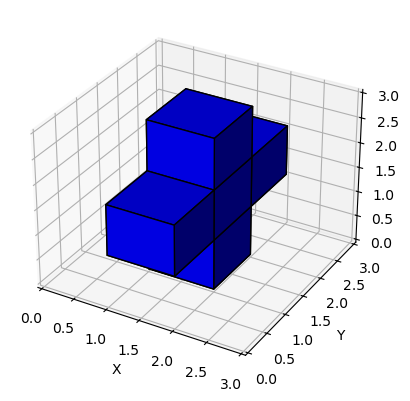

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the voxel grid
voxel_grid = np.array([
	[[0, 0, 0], [0, 0, 0], [0, 0, 0]],
	[[0, 1, 0], [1, 1, 1], [0, 1, 0]],
	[[0, 0, 0], [0, 0, 0], [0, 0, 0]]
])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the voxel grid
ax.voxels(voxel_grid, facecolors='blue', edgecolor='k')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set limits to match the grid size
ax.set_xlim([0, voxel_grid.shape[0]])
ax.set_ylim([0, voxel_grid.shape[1]])
ax.set_zlim([0, voxel_grid.shape[2]])

plt.show()


Merged Voxels:
[[[1 1 0]
  [0 1 1]]

 [[1 1 1]
  [1 0 1]]

 [[1 0 1]
  [1 1 1]]]
Rectangles List (x, y, z_start, length):
[(0, 0, 0, 2), (0, 1, 1, 2), (1, 0, 0, 3), (1, 1, 0, 1), (1, 1, 2, 1), (2, 0, 0, 1), (2, 0, 2, 1), (2, 1, 0, 3)]
Visited Array:
[[[ True  True False]
  [False  True  True]]

 [[ True  True  True]
  [ True False  True]]

 [[ True False  True]
  [ True  True  True]]]


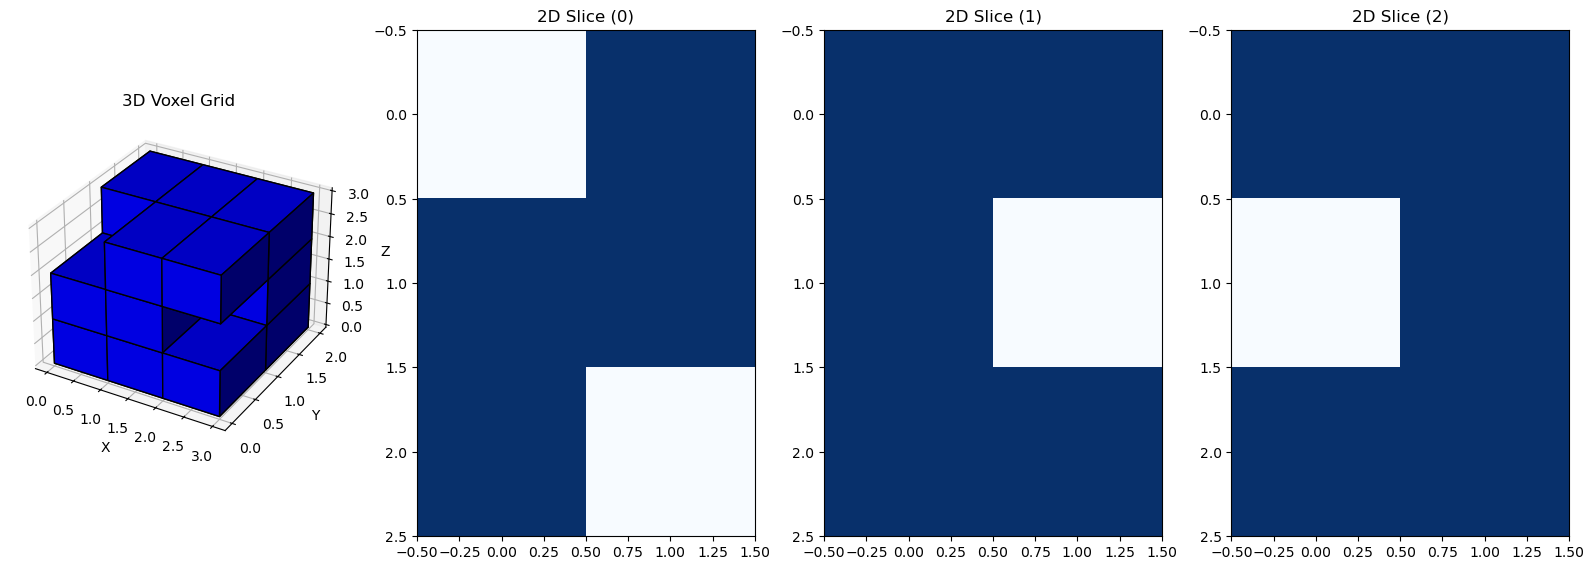

In [9]:
import numpy as np

def merge_vertical_voxels(vox):
	"""
	Merges vertical stacks of filled voxels (value of 1) along the z-axis into single or multiple rectangular voxels,
	accounting for gaps in between, and tracks which voxels have been processed.

	Parameters:
	- vox: The 3D numpy array representing the voxel grid.

	Returns:
	- merged_vox: A new 3D numpy array with merged vertical stacks.
	- rect_list: A list of tuples representing the merged rectangles in the form (x_index, y_index, z_start, length).
	- visited: A 3D numpy array indicating which voxels have been processed.
	"""
	merged_vox = np.zeros_like(vox)
	visited = np.zeros_like(vox, dtype=bool)
	rect_list = []

	for i in range(vox.shape[0]):
		for j in range(vox.shape[1]):
			k = 0
			while k < vox.shape[2]:
				if vox[i, j, k] == 1 and not visited[i, j, k]:
					start_k = k
					while k < vox.shape[2] and vox[i, j, k] == 1:
						k += 1
					length = k - start_k  # Calculate the length of the rectangle
					# Store the rectangular voxel's starting z-index and length along with x and y indices
					rect_list.append((i, j, start_k, length))
					# Mark all the voxels in this rectangle as visited
					merged_vox[i, j, start_k:start_k+length] = 1
					visited[i, j, start_k:start_k+length] = True  # Mark as visited after forming the rectangle
				else:
					k += 1  # Move to the next voxel if this one is not part of a new rectangle

	return merged_vox, rect_list, visited

def sort_rectangles_for_xy_touching(rect_list):
	"""
	Sorts rectangles so that each rectangle touches the next one along the x or y axis.
	Parameters:
	- rect_list: A list of tuples representing the rectangles in the form (x_index, y_index, z_start, length).
	Returns:
	- sorted_rect_list: A sorted list of tuples where each rectangle touches the next one along the x or y axis.
	"""
	# First, sort by x_index and y_index to get a baseline order
	rect_list.sort(key=lambda x: (x[0], x[1]))
	sorted_rect_list = []

	if not rect_list:
		return sorted_rect_list

	# Start with the first rectangle
	current_rect = rect_list[0]
	sorted_rect_list.append(current_rect)
	rect_list = rect_list[1:]
	
	while rect_list:
		next_rect = None
		for i, rect in enumerate(rect_list):
			# Check if the rectangle can touch the current one along the x or y axis
			if (rect[0] == current_rect[0] and abs(rect[1] - current_rect[1]) == 1) or \
			(rect[1] == current_rect[1] and abs(rect[0] - current_rect[0]) == 1):
				next_rect = rect
				break
		
		if next_rect:
			sorted_rect_list.append(next_rect)
			rect_list.pop(i)
			current_rect = next_rect
		else:
			# If no touching rectangle is found, add the next available rectangle and continue
			current_rect = rect_list.pop(0)
			sorted_rect_list.append(current_rect)
	return sorted_rect_list


# Example usage:
vox = np.array([[[1, 1, 0], [0, 1, 1]], [[1, 1, 1], [1, 0, 1]], [[1, 0, 1], [1, 1, 1]]])
merged_vox, rect_list, visited = merge_vertical_voxels(vox)

print("Merged Voxels:")
print(merged_vox)
print("Rectangles List (x, y, z_start, length):")
print(rect_list)
print("Visited Array:")
print(visited)


# merged_vox[0,0]

# Create a 3D plot
fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(111, projection='3d')

# Plot the voxel grid
# ax.voxels(merged_vox, facecolors='blue', edgecolor='k')

# Set labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# vox = np.array([[[1, 1, 0], [0, 1, 1]], [[1, 1, 1], [1, 0, 1]], [[1, 0, 1], [1, 1, 1]]])

# First subplot: 3D voxel grid
ax1 = fig.add_subplot(141, projection='3d')
ax1.voxels(merged_vox, facecolors='blue', edgecolor='k')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Voxel Grid')

# Second subplot: 2D slice of the voxel grid
ax2 = fig.add_subplot(142)
ax2.imshow(np.rot90(merged_vox[0], k=1), cmap='Blues', interpolation='none')
ax2.set_title('2D Slice (0)')
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')

# Second subplot: 2D slice of the voxel grid
ax2 = fig.add_subplot(143)
ax2.imshow(np.rot90(merged_vox[1], k=1), cmap='Blues', interpolation='none')
ax2.set_title('2D Slice (1)')
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')

# Second subplot: 2D slice of the voxel grid
ax2 = fig.add_subplot(144)
ax2.imshow(np.rot90(merged_vox[2], k=1), cmap='Blues', interpolation='none')
ax2.set_title('2D Slice (2)')
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')

# Show the plots
plt.tight_layout()
plt.show()
